In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from neurasort.preprocessing import free_whisking_preprocessing_pipe

# 0.0 Load raw prediction data for the free whisking setting

In [2]:
# data_ohe_scaled_constant_free_filled = pd.read_csv("data_ohe_scaled_constant_free_filled.csv")
# data_ohe_scaled_constant_free_filled

raw_predictors_free_whisking = pd.read_csv("raw_predictors_free_whisking.csv")
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer,Cell_tdTomatoExpressing
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518,10.0,229.0,L2/3,False
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485,10.0,350.0,L2/3,False
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519,10.0,350.0,L2/3,False
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557,10.0,350.0,L2/3,False
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403,10.0,244.0,L2/3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438,20.0,196.0,L2/3,True
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514,20.0,196.0,L2/3,True
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460,20.0,196.0,L2/3,True
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430,20.0,196.0,L2/3,True


In [ ]:
#raw_predictors_free_whisking = raw_predictors_free_whisking.drop(["Cell_tdTomatoExpressing"], axis=1)

In [ ]:
#raw_predictors_free_whisking

# 0.1 Create the free whisking preprocessing pipeline

In [3]:
preprocessing_pipe = free_whisking_preprocessing_pipe()

# 0.2 Calculate the class weights

In [4]:
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
class_weights

{'SST': 0.6921529175050302,
 'EXC': 0.7062374245472838,
 'PV': 0.7565392354124748,
 'VIP': 0.8450704225352113}

# 0.3 Create list of models to test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
models = [
    LogisticRegression(random_state=0, class_weight=class_weights),
    RandomForestClassifier(random_state=0, class_weight=class_weights), 
    GradientBoostingClassifier(random_state=0), 
    AdaBoostClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0, class_weight=class_weights),
    SVC(random_state=0, class_weight=class_weights), 
    NuSVC(random_state=0, class_weight=class_weights), 
    LinearSVC(random_state=0, class_weight=class_weights),
    GaussianNB(),
]

# 1.0 Test all the models in the list

In [ ]:
from sklearn.model_selection import StratifiedKFold
from neurasort.model_eval import fit_models_get_CV_scores

In [ ]:
cv_scores_df = fit_models_get_CV_scores(
    models=models,
    X = raw_predictors_free_whisking.drop("cell_type", axis=1),
    y = raw_predictors_free_whisking["cell_type"],
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring={
        "f1":"f1_weighted", 
        "accuracy":"accuracy",
        "recall":"recall_weighted",
        "precision":"precision_weighted"
    },
    preprocessing_pipe=preprocessing_pipe,
)
cv_scores_df

# 1.1 Plot the results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ax = sns.barplot(
    data=cv_scores_df.melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
    x="model",
    y="value",
    hue="measurement"
)
ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

# 1.2 Tune the 3 best models

## 1.2.0 GradientBoostingClassifier

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

In [ ]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(random_state=0))
)
clf_pipe

In [ ]:
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(10, 500),
        # "estimator": Categorical(
        #     [None, RandomForestClassifier(random_state=0)]
        # ),
        "clf__learning_rate": Real(1e-3, 1, "log-uniform"),
    },
    n_iter=75,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)

In [ ]:
plot_objective(opt.optimizer_results_[0])

In [ ]:
opt.best_score_, opt.best_params_

## 1.2.1 SVC

In [ ]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", SVC(random_state=0))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__gamma": Categorical(['scale', 'auto']),
        "clf__kernel": Categorical(
            ['linear', 'poly', 'rbf', 'sigmoid']
        ),
        "clf__C": Real(1, 10, "uniform"),
    },
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

## 1.2.2 RandomForestClassifier

In [ ]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", RandomForestClassifier(random_state=0, class_weight=class_weights))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(10, 500),
        "clf__criterion": Categorical(['gini', 'entropy', 'log_loss']),
    },
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

# 2.0 Test a Neural Network

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [6]:
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(raw_predictors_free_whisking["cell_type"]))
X_train, X_test, y_train, y_test = train_test_split(
    raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y, 
    test_size=0.33, 
    random_state=42
)
X_train = preprocessing_pipe.fit_transform(X_train)
X_test = preprocessing_pipe.transform(X_test)

class_weights = (1 - y.value_counts() / y.shape[0])
class_weights

2    0.692153
0    0.706237
1    0.756539
3    0.845070
Name: count, dtype: float64

## 2.1 With Pytorch

In [ ]:
from neurasort.sktorch import FeedForwardExample
import torch.nn as nn
import torch

In [ ]:
torch_class_weights = torch.tensor(list(class_weights.values()))
torch_class_weights

In [ ]:
import random

random_state = 0
# Reproducibility
random.seed(random_state)
np.random.seed(random_state)
torch.use_deterministic_algorithms(True)


nn_model = FeedForwardExample(
    num_epochs=100,
    optimizer_class=torch.optim.AdamW,
    loss_function=nn.CrossEntropyLoss(weight=torch_class_weights),
    batch_size=64,
    lr=1e-4,
    save_train_loss=True,
    num_classes=4,
)
nn_model.fit(
    X = X_train,
    y = y_train,
    X_val=X_test,
    y_val=y_test,
)
plt.plot(nn_model.training_loss, label="training set")
plt.plot(nn_model.validation_loss, label="validation set")
plt.xlabel("epochs")
plt.ylabel("cross-entropy loss")
plt.legend()
f1_score(y_train, nn_model.predict(X_train), average="weighted"), f1_score(y_test, nn_model.predict(X_test), average="weighted")

In [ ]:
import random

random_state = 0
# Reproducibility
random.seed(random_state)
np.random.seed(random_state)
print(torch.seed())
torch.use_deterministic_algorithms(True)


nn_model = FeedForwardExample(
    num_epochs=100,
    optimizer_class=torch.optim.AdamW,
    loss_function=nn.CrossEntropyLoss(weight=torch_class_weights),
    batch_size=64,
    lr=1e-4,
    save_train_loss=True,
    num_classes=4,
)
nn_model.fit(
    X = X_train,
    y = y_train,
    X_val=X_test,
    y_val=y_test,
)
plt.plot(nn_model.training_loss, label="training set")
plt.plot(nn_model.validation_loss, label="validation set")
plt.xlabel("epochs")
plt.ylabel("cross-entropy loss")
plt.legend()
f1_score(y_train, nn_model.predict(X_train), average="weighted"), f1_score(y_test, nn_model.predict(X_test), average="weighted")

## 2.2 With Keras & TF

In [7]:
from scikeras.wrappers import KerasRegressor, KerasClassifier
from neurasort.model_tf import create_model
from keras.utils import to_categorical
import tensorflow as tf

In [8]:
tf.keras.utils.set_random_seed(
    42
)

y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [9]:
clf_tf = KerasClassifier(
     build_fn=create_model(lr=1e-4, optimizer='adam'),
     verbose=1
)

#clf = create_model()

2023-12-12 12:08:14.465378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-12 12:08:14.465396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 12:08:14.465400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 12:08:14.465430: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 12:08:14.465444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
clf_tf.fit(
     X = X_train,
     y = y_train_one_hot,
     validation_data = [X_test, y_test_one_hot],
     epochs = 115,
     batch_size = 16
)

# clf.fit(
#     X_train,
#     y_train_one_hot,
#     validation_data = [X_test, y_test_one_hot],
#     epochs = 20,
#     batch_size = 4
# )

Epoch 1/115


/Users/mariannescoglio/anaconda3/envs/bio482/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 1/21 [>.............................] - ETA: 7s - loss: 1.3761 - f1_score: 0.2212

2023-12-12 12:08:15.758273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 27ms/step - loss: 1.3221 - f1_score: 0.2486 - val_loss: 1.2548 - val_f1_score: 0.3498
Epoch 2/115
21/21 [==============================] - 0s 13ms/step - loss: 1.2710 - f1_score: 0.3835 - val_loss: 1.2126 - val_f1_score: 0.4108
Epoch 3/115
21/21 [==============================] - 0s 14ms/step - loss: 1.2285 - f1_score: 0.4298 - val_loss: 1.1823 - val_f1_score: 0.4639
Epoch 4/115
21/21 [==============================] - 0s 12ms/step - loss: 1.1939 - f1_score: 0.4531 - val_loss: 1.1551 - val_f1_score: 0.4727
Epoch 5/115
21/21 [==============================] - 0s 12ms/step - loss: 1.1629 - f1_score: 0.4542 - val_loss: 1.1327 - val_f1_score: 0.4846
Epoch 6/115
21/21 [==============================] - 0s 12ms/step - loss: 1.1352 - f1_score: 0.4823 - val_loss: 1.1095 - val_f1_score: 0.4950
Epoch 7/115
21/21 [==============================] - 0s 12ms/step - loss: 1.1104 - f1_score: 0.4949 - val_loss: 1.0882 - val_f1_score: 0.5145
Epoch 8/115
21/21 

KerasClassifier(
	model=None
	build_fn=<keras.src.engine.sequential.Sequential object at 0x2b059a3e0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [ ]:
clf_tf.history_.keys()

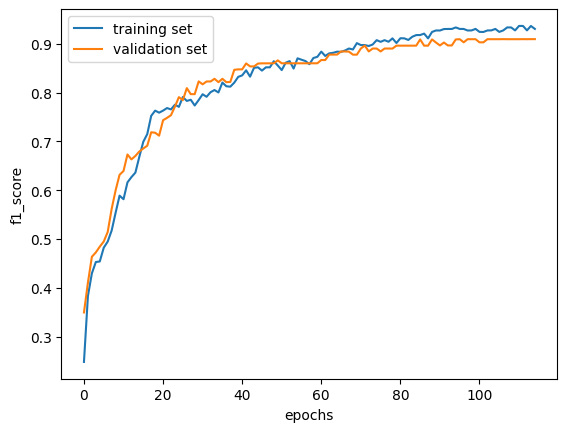

In [11]:
plt.plot(clf_tf.history_["f1_score"], label="training set")
plt.plot(clf_tf.history_["val_f1_score"], label="validation set")
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.legend()

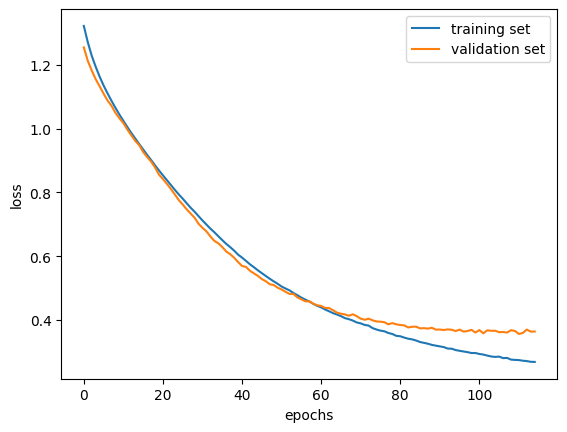

In [12]:
plt.plot(clf_tf.history_["loss"], label="training set")
plt.plot(clf_tf.history_["val_loss"], label="validation set")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [13]:
from sklearn.metrics import f1_score
f1_score(y_test_one_hot,clf_tf.predict(X_test), average='weighted')

6/6 [==============================] - 0s 2ms/step


0.909346316653056

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

#Best: 0.936065 using {'batch_size': 4, 'loss': 'categorical_crossentropy', 'lr': 0.0001, 'optimizer': 'adagrad'}

param_grid = {
    'optimizer': ['adam', 'adagrad', 'adamax', 'adaw'],
    'batch_size': [4, 8, 16],
    'lr' : [1e-3, 1e-4, 1e-5],
    #'loss' : ['categorical_crossentropy', 'weighted_categorical_crossentropy']
}

clf_tf = KerasClassifier(build_fn=create_model, lr=0.01,verbose=0)

f1_weighted_scorer = make_scorer(f1_score, average='weighted')
grid = GridSearchCV(estimator=clf_tf, param_grid=param_grid, cv=3, scoring=f1_weighted_scorer)
grid_result = grid.fit(X_train, y_train_one_hot, epochs = 400)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
